In [5]:
import json
import datetime
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
gopatriots_json=[]
gohawks_json=[]
nfl_time=[]
patriots_json=[]
sb49_json=[]
superbowl_json=[]
Files=[]
Files=['tweets_#gopatriots.txt']

In [21]:
for line in open('./ECE219_tweet_data/tweets_#gopatriots.txt'):
    json_object = json.loads(line)
    gopatriots_json.append(json_object)
print('load finish')

load finish


In [ ]:
for line in open('./ECE219_tweet_data/tweets_#nfl.txt'):
    json_object = json.loads(line)
    nfl_time.append(json_object['citation_date'])
print('load finish')

In [ ]:
for line in open('./ECE219_tweet_data/tweets_#patriots.txt'):
    json_object = json.loads(line)
    patriots_json.append(json_object)  
print('load finish')

In [ ]:
for line in open('./ECE219_tweet_data/tweets_#sb49.txt'):
    json_object = json.loads(line)
    sb49_json.append(json_object)
print('load finish')

In [ ]:
for line in open('./ECE219_tweet_data/tweets_#superbowl.txt'):
    json_object = json.loads(line)
    superbowl_json.append(json_object)
print('load finish')

In [ ]:
tweet_number=len(gopatriots_json)
print(tweet_number)
gopatriots_time_delta=gopatriots_json[-1]['citation_date']-gopatriots_json[0]['citation_date']
gopatriots_hour_delta=round((time_delta.seconds/3600),2)
follower_sum=0
retweet_sum=0
for i in range(tweet_number):
    follower_sum += gopatriots_json[i]['author']['followers']
    retweet_sum += gopatriots_json[i]['metrics']['citations']['total']
    
print(follower_sum)
print(retweet_sum)
print('#gopatriots average tweets per hour:',tweet_number/gopatriots_hour_delta)
print('#gopatriots average followers per tweet',follower_sum/tweet_number)
print('#gopatriots average retweets per tweet',retweet_sum/tweet_number)

In [7]:
def plothist(file):
    with open(file,mode='r') as currentfile:
        lines=currentfile.readlines()
        json_object=json.loads(lines[-1])
        endtime=json_object['citation_date']
    
        json_object=json.loads(lines[0])
        starttime=json_object['citation_date']
        timespan=int(math.floor((endtime-starttime)/3600))
        timearray=[i for i in range(timespan+1)]
        tweets_per_hour=np.zeros(timespan+1)

        for line in lines:
            json_object=json.loads(line)
            currenthour = int(math.floor((json_object['citation_date']-starttime)/3600))
            tweets_per_hour[currenthour]+=1
    
        plt.figure(figsize=(10,8))
        plt.bar(timearray, tweets_per_hour, 1, align='edge', color = 'lightseagreen')
        plt.title('Number of Tweets in Hour (' + file[20:-4] + ')')
        plt.xlabel('Time/hour', fontsize = 18)
        plt.ylabel('Number of Tweets', fontsize = 18)
        plt.show()
    

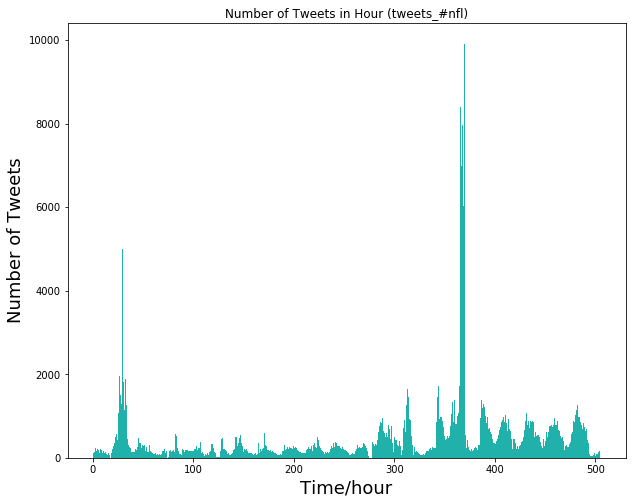

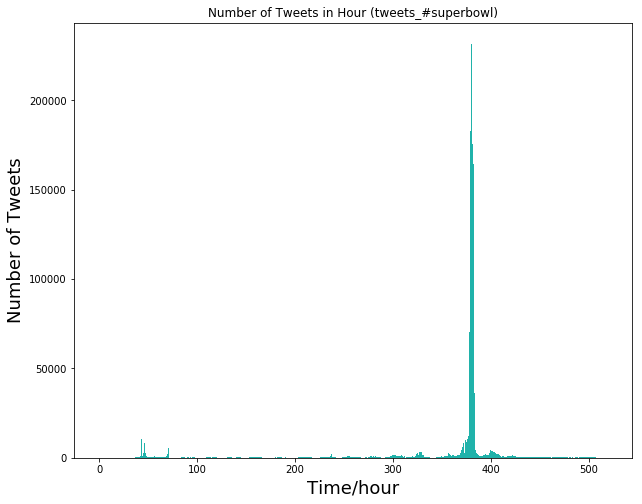

In [8]:
plothist('./ECE219_tweet_data/tweets_#nfl.txt')
plothist('./ECE219_tweet_data/tweets_#superbowl.txt')

Question 6

In [14]:
# define paths
files = ['ECE219_tweet_data/tweets_#gohawks.txt', 
         'ECE219_tweet_data/tweets_#gopatriots.txt', 
         'ECE219_tweet_data/tweets_#nfl.txt', 
         'ECE219_tweet_data/tweets_#patriots.txt', 
         'ECE219_tweet_data/tweets_#sb49.txt', 
         'ECE219_tweet_data/tweets_#superbowl.txt']



In [32]:
import pytz
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
pst_tz = pytz.timezone('America/Los_Angeles')
superbowl=datetime.datetime.fromtimestamp(1422806400,pst_tz)
print(superbowl.hour)
#sb_start=1422806400  #pacific time zone
sb_start=1422777600 # UTC  Superbowl start time
#sb_end=1422849600    #pacific
sb_end=1422820800  #UTC    Superbowl end time

8


In [6]:
def windowconstruction(file):
    
    window1=[]
    window2=[]
    window3=[]
    timearray=[]
    with open(file,mode='r') as currentfile:
        lines=currentfile.readlines()
        for line in lines:
            json_object=json.loads(line)
            time=json_object['citation_date']
            timearray.append(time)
            if time <= sb_start:
                window1.append(line)
            elif time > sb_start and time <= sb_end:
                window2.append(line)
            else:
                window3.append(line)

    starttime=min(timearray)
    endtime=max(timearray)
    return window1,window2,window3,starttime,endtime

In [7]:
# need the startline for each window in lines
def constructfeature_predict(window,x,y,interval,starttime,filename,windownumber):
    prev_follwer_count=0
    currenthour=0
    for i in range(len(window)) :
        json_object=json.loads(window[i])
        time=json_object['citation_date']
        currenthour = int(math.floor((time-starttime)/interval))
        y[currenthour]+=1        #mapping
        x[currenthour][0]+=1
        x[currenthour][1]+=json_object['metrics']['citations']['total'] #retweet count
        number_follower=json_object['author']['followers']
        x[currenthour][2]+=number_follower #total followers
        if number_follower>prev_follwer_count:#keep maximum follower 
            x[currenthour][3]=number_follower
            prev_follower_count=number_follower
        datetimeobject=datetime.datetime.fromtimestamp(json_object['citation_date'],pst_tz)
        x[currenthour][4]=datetimeobject.hour
        
   
    x_train=np.delete(x,-1,0)
    y_train=np.delete(y,0)
    reg = LinearRegression().fit(x_train, y_train)
    y_predicted =reg.predict(x_train)
    print(filename,'window',windownumber,'mean squared error is:',mean_squared_error(y_predicted,y_train))
    print(filename,'window',windownumber,'r2_score is:',r2_score(y_predicted,y_train))

In [8]:
# piecewiselinear takes 20 seconds to 3 minutes to run depending on input data size
def Piecewiselinear(file):
    filename=file[26:-4]
    window1=[]
    window2=[]
    window3=[]
    starttime=0
    endtime=0
    window1,window2,window3,starttime,endtime=windowconstruction(file)
    #construct feature for window 1 and window3
    window1size=len(window1)
    window2size=len(window2)
    window3size=len(window3)
        
    y1=np.zeros(window1size)
    x1=np.zeros((window1size,5))
        
    y2=np.zeros(window2size)
    x2=np.zeros((window2size,5))
        
    y3=np.zeros(window3size)
    x3=np.zeros((window3size,5))
    
        
    constructfeature_predict(window1,x1,y1,3600,starttime,filename,1)
    constructfeature_predict(window2,x2,y2,300,sb_start,filename,2)
    constructfeature_predict(window3,x3,y3,3600,sb_end,filename,3)    
        
        

In [133]:
Piecewiselinear(files[0])

gohawks window 1 mean squared error is: 2911.47352883
gohawks window 1 r2_score is: -0.819857385959
gohawks window 2 mean squared error is: 16.4327536204
gohawks window 2 r2_score is: 0.904155782898
gohawks window 3 mean squared error is: 1282.56716821
gohawks window 3 r2_score is: 0.765848720433


In [134]:
Piecewiselinear(files[1])

gopatriots window 1 mean squared error is: 183.902439018
gopatriots window 1 r2_score is: -0.164492000305
gopatriots window 2 mean squared error is: 3.05335927054
gopatriots window 2 r2_score is: 0.845649298688
gopatriots window 3 mean squared error is: 819.151921491
gopatriots window 3 r2_score is: 0.500265059923


In [131]:
Piecewiselinear(files[2])

nfl window 1 mean squared error is: 256.295654379
nfl window 1 r2_score is: 0.491896962387
nfl window 2 mean squared error is: 9.38114530729
nfl window 2 r2_score is: 0.879968950277
nfl window 3 mean squared error is: 1176.12207656
nfl window 3 r2_score is: 0.461609675019


In [136]:
Piecewiselinear(files[3])

patriots window 1 mean squared error is: 1731.13327722
patriots window 1 r2_score is: -0.179348448953
patriots window 2 mean squared error is: 381.198921015
patriots window 2 r2_score is: 0.87910454422
patriots window 3 mean squared error is: 3504.4847578
patriots window 3 r2_score is: 0.79830245117


In [137]:
Piecewiselinear(files[4])

sb49 window 1 mean squared error is: 59.0806408646
sb49 window 1 r2_score is: 0.854056223832
sb49 window 2 mean squared error is: 848.304294465
sb49 window 2 r2_score is: 0.870212141442
sb49 window 3 mean squared error is: 3545.96343988
sb49 window 3 r2_score is: 0.929648554587


In [140]:
Piecewiselinear(files[5])

superbowl window 1 mean squared error is: 1409.49535036
superbowl window 1 r2_score is: -0.65779343813
superbowl window 2 mean squared error is: 34.5581637759
superbowl window 2 r2_score is: 0.939890160429
superbowl window 3 mean squared error is: 28771.6052646
superbowl window 3 r2_score is: 0.775723681194


Question 7

In [15]:
def getcsv2(file):
    timestamp = []
    tweet_count = []
    followers_count = []
    retweet_count = []
    url_count=[]
    user_mentions=[]
    favorited_num=[]
    ranking_score=[]
    hashtag_number=[]
    with open(file, 'r') as fl:
        for line in fl:
            data = json.loads(line)
            timestamp.append(data['citation_date'])
            tweet_count.append(1)
            followers_count.append(data['author']['followers'])
            retweet_count.append(data['metrics']['citations']['total'])
            url_count.append(len(data['tweet']['entities']['urls']))
            user_mentions.append(len(data['tweet']['entities']['user_mentions']))
            favorited_num.append(data['tweet']['favorite_count'])
            ranking_score.append(data['metrics']['ranking_score'])
            hashtag_number.append(data['title'].count('#'))
        df = pd.DataFrame({
            'tweet' : tweet_count,
            'timestamp' : timestamp,
            'followers' : followers_count,
            'retweeted times' : retweet_count,
            'url count':url_count,
            'user mention':user_mentions,
            'favorited num':favorited_num,
            'ranking score': ranking_score,
            'hashtag count':hashtag_number
        }, columns = ['tweet', 'timestamp', 'followers', 'retweeted times','url count','user mention','favorited num','ranking score','hashtag count'])
        df.to_csv('part1_7'+file[26:-4]+'.csv', index = False)

for file in files:
    getcsv2(file)

In [18]:
newfiles2 = ['part1_7gohawks.csv', 
         'part1_7gopatriots.csv', 
         'part1_7nfl.csv', 
         'part1_7patriots.csv', 
         'part1_7sb49.csv', 
         'part1_7superbowl.csv']

In [86]:
data = pd.read_csv(newfiles2[0],dtype='float32')
data.columns = ['tweet', 'timestamp', 'followers', 'retweets','url count','user mention','favorited num','ranking score','hashtag count']
print(data.loc[0]['timestamp'])
print(data.loc[1]['timestamp'])
print(data.loc[2]['timestamp'])
c=[]
a=data.loc[3]
c.append(a)
b=data.loc[4]
c.append(b)
#print(c[1])

data=data.drop(['url count','user mention','favorited num','ranking score','hashtag count'],axis=1)
print(data.loc[0])
window1=data.query('timestamp<=1422777600')
print(window1['tweet'].count())
print(window1['tweet'].max())

1.42152e+09
1.42126e+09
1.42147e+09
tweet        1.000000e+00
timestamp    1.421519e+09
followers    1.752000e+03
retweets     5.000000e+00
Name: 0, dtype: float32
105653
1.0


In [105]:
#Aggregate data and construct windows
#Alltimearray=[]
Allwindow1=[]
Allwindow2=[]
Allwindow3=[]
for file in newfiles2:
    data = pd.read_csv(file,dtype='float32')
    rownumber=data['tweet'].count()
    data.columns = ['tweet', 'timestamp', 'followers', 'retweets','url count','user mention','favorited num','ranking score','hashtag count']
    data=data.drop(['url count','user mention','favorited num','ranking score','hashtag count'],axis=1)
    
    Allwindow1=data.query('timestamp<=1422777600')
    Allwindow2=data.query('timestamp<=1422820800 and timestamp>1422777600')
    Allwindow3=data.query('timestamp>1422820800')
Allstarttime=data['timestamp'].max()
Allendtime=data['timestamp'].min()   
print('done')

done


In [103]:
 def constructfeature_predict2(window,x,y,interval,starttime,filename,windownumber):
    prev_follwer_count=0
    currenthour=0
    for i in range(window['tweet'].count()) :
        time=window.iloc[i]['timestamp']
        currenthour = int(math.floor((time-starttime)/interval))
        y[currenthour]+=1        #mapping
        x[currenthour][0]+=1
        x[currenthour][1]+=window.iloc[i]['retweets'] #retweet count
        number_follower=window.iloc[i]['followers']
        x[currenthour][2]+=number_follower #total followers
        if number_follower>prev_follwer_count:#keep maximum follower 
            x[currenthour][3]=number_follower
            prev_follower_count=number_follower
        datetimeobject=datetime.datetime.fromtimestamp(time,pst_tz)
        x[currenthour][4]=datetimeobject.hour
        
   
    x_train=np.delete(x,-1,0)
    y_train=np.delete(y,0)
    reg = LinearRegression().fit(x_train, y_train)
    y_predicted =reg.predict(x_train)
    print(filename,'window',windownumber,'mean squared error is:',mean_squared_error(y_predicted,y_train))
    print(filename,'window',windownumber,'r2_score is:',r2_score(y_predicted,y_train))
    return x_train, y_train

In [106]:
    # predict using all data   
window1size=Allwindow1['tweet'].count()
y1=np.zeros(window1size)
x1=np.zeros((window1size,5))
print('half success')
constructfeature_predict2(Allwindow1,x1,y1,3600,Allstarttime,'Alldata',1)
    

half success
Alldata window 1 mean squared error is: 1191.21956952
Alldata window 1 r2_score is: -0.285656614437


In [109]:
window2size=Allwindow2['tweet'].count()
y2=np.zeros(window2size)
x2=np.zeros((window2size,5))
print('half success')
constructfeature_predict2(Allwindow2,x2,y2,300,Allstarttime,'Alldata',2)        

half success
Alldata window 2 mean squared error is: 87.3990853005
Alldata window 2 r2_score is: 0.841317670699


In [108]:
window3size=Allwindow3['tweet'].count()
y3=np.zeros(window3size)
x3=np.zeros((window3size,5))
print('half success')
constructfeature_predict2(Allwindow3,x3,y3,3600,Allstarttime,'Alldata',3)  

half success
Alldata window 3 mean squared error is: 31465.9316734
Alldata window 3 r2_score is: 0.750414614479


Q8

In [115]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
parameters={
'max_depth': [10, 20, 40, 60, 80, 100, 200, None],
'max_features': ['auto', 'sqrt'],
'min_samples_leaf': [1, 2, 4],
'min_samples_split': [2, 5, 10],
'n_estimators': [200, 400, 600, 800, 1000,
1200, 1400, 1600, 1800, 2000]
}
Aggregatedwindow=Allwindow1.append(Allwindow2)
Aggregatedwindow=Aggregatedwindow.append(Allwindow3)
Q8starttime=Aggregatedwindow['timestamp'].max()
Q8endtime=Aggregatedwindow['timestamp'].min() 

In [121]:
    # construct feature for aggregated data   
    windowsize=Aggregatedwindow['tweet'].count()
    ytrain=np.zeros(windowsize)
    xtrain=np.zeros((windowsize,5))
    prev_follwer_count=0
    currenthour=0
    for i in range(Aggregatedwindow['tweet'].count()) :
        time=Aggregatedwindow.iloc[i]['timestamp']
        currenthour = int(math.floor((time-Q8starttime)/3600))
        ytrain[currenthour]+=1        #mapping
        xtrain[currenthour][0]+=1
        xtrain[currenthour][1]+=Aggregatedwindow.iloc[i]['retweets'] #retweet count
        number_follower=Aggregatedwindow.iloc[i]['followers']
        xtrain[currenthour][2]+=number_follower #total followers
        if number_follower>prev_follwer_count:#keep maximum follower 
            xtrain[currenthour][3]=number_follower
            prev_follower_count=number_follower
        datetimeobject=datetime.datetime.fromtimestamp(time,pst_tz)
        xtrain[currenthour][4]=datetimeobject.hour
        
    
    x_train=np.delete(xtrain,-1,0)
    y_train=np.delete(ytrain,0)
    print('done')

done


In [ ]:
from sklearn.model_selection import KFold
reg=GridSearchCV(RandomForestRegressor(),parameters,cv = KFold(5, shuffle=True), scoring='neg_mean_squared_error',verbose=10,n_jobs=4)
reg.fit(x_train,y_train)
print('done')

In [ ]:
print(reg.best_estimator_)
print(reg.best_score_)

In [ ]:
from sklearn.model_selection import KFold
reg=GridSearchCV(GradientBoostingRegressor(),parameters,cv = KFold(5, shuffle=True), scoring='neg_mean_squared_error',verbose=10)
reg.fit(x_train,y_train)
print('done')

Q9

In [ ]:
 def constructfeature_predict3(window,x,y,interval,starttime,filename,windownumber,model):
    prev_follwer_count=0
    currenthour=0
    for i in range(window['tweet'].count()) :
        time=window.iloc[i]['timestamp']
        currenthour = int(math.floor((time-starttime)/interval))
        y[currenthour]+=1        #mapping
        x[currenthour][0]+=1
        x[currenthour][1]+=window.iloc[i]['retweets'] #retweet count
        number_follower=window.iloc[i]['followers']
        x[currenthour][2]+=number_follower #total followers
        if number_follower>prev_follwer_count:#keep maximum follower 
            x[currenthour][3]=number_follower
            prev_follower_count=number_follower
        datetimeobject=datetime.datetime.fromtimestamp(time,pst_tz)
        x[currenthour][4]=datetimeobject.hour
        
   
    x_train=np.delete(x,-1,0)
    y_train=np.delete(y,0)
    reg=GridSearchCV(GradientBoostingRegressor(),parameters,cv = KFold(5, shuffle=True), scoring='neg_mean_squared_error',verbose=10,n_jobs=-1)
    reg.fit(x_train,y_train)
    return reg

In [ ]:
window1size=Allwindow1['tweet'].count()
y1=np.zeros(window1size)
x1=np.zeros((window1size,5))
print('half success')
reg1=constructfeature_predict3(Allwindow1,x1,y1,3600,Allstarttime,'Alldata',1,GradientBoostingRegressor())
print('window1 error',reg1.best_score_)
print('window1 best parameter',reg1.best_params_)

In [ ]:
window2size=Allwindow2['tweet'].count()
y2=np.zeros(window2size)
x2=np.zeros((window2size,5))
print('half success')
reg2=constructfeature_predict3(Allwindow2,x2,y2,300,Allstarttime,'Alldata',2,GradientBoostingRegressor())
print('window2 error',reg2.best_score_)
print('window2 best parameter',reg2.best_params_)

In [ ]:
window3size=Allwindow3['tweet'].count()
y3=np.zeros(window3size)
x3=np.zeros((window3size,5))
print('half success')
reg3=constructfeature_predict3(Allwindow3,x3,y3,3600,Allstarttime,'Alldata',3,GradientBoostingRegressor()) 
print('window3 error',reg3.best_score_)
print('window3 best parameter',reg3.best_params_)

Q11

In [129]:
from sklearn.neural_network import MLPRegressor


Archiectures
Number of Layers: 1,2,3,4
hidden layer size: 5,50,100,200

In [227]:
Model1=MLPRegressor(hidden_layer_sizes=(200,),
             activation='relu',
             solver='adam',
             learning_rate='adaptive',
             max_iter=200,
             learning_rate_init=0.01,
             alpha=0.01,
             verbose=10,       
                   )

In [220]:
Model1.fit(x_train,y_train)
y_predicted =Model1.predict(x_train)
print('MSE for model1 is:',mean_squared_error(y_predicted,y_train))

Iteration 1, loss = 210482313494.93057251
Iteration 2, loss = 32908806749.53373337
Iteration 3, loss = 12147549551.42066574
Iteration 4, loss = 64441.45115446
Iteration 5, loss = 64440.93282094
Iteration 6, loss = 64439.36447555
Iteration 7, loss = 84337.43934543
Iteration 8, loss = 1259972441.85294890
Iteration 9, loss = 46318856.14218003
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
MSE for model1 is: 128586.328576


In [221]:
Model2=MLPRegressor(hidden_layer_sizes=(200,200),
             activation='relu',
             solver='adam',
             learning_rate='adaptive',
             max_iter=200,
             learning_rate_init=0.01,
             alpha=0.0001,
              verbose=10
              )

In [222]:
Model2.fit(x_train,y_train)
y_predicted2 =Model2.predict(x_train)
print('MSE for model2 is:',mean_squared_error(y_predicted2,y_train))

Iteration 1, loss = 373996582.58210433
Iteration 2, loss = 1545902.20182140
Iteration 3, loss = 64231.36525929
Iteration 4, loss = 65395.09777285
Iteration 5, loss = 78812.07450434
Iteration 6, loss = 6157495.81078130
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
MSE for model2 is: 127585.547422


In [223]:
Model3=MLPRegressor(hidden_layer_sizes=(200,200,200),
             activation='relu',
             solver='adam',
             learning_rate='adaptive',
             max_iter=200,
             learning_rate_init=0.01,
             alpha=0.01,
             verbose=10
                   )

In [224]:
Model3.fit(x_train,y_train)
y_predicted3 =Model3.predict(x_train)
print('MSE for model3 is:',mean_squared_error(y_predicted3,y_train))

Iteration 1, loss = 1095824453.26408100
Iteration 2, loss = 64186.49625969
Iteration 3, loss = 63874.92096887
Iteration 4, loss = 63859.08883148


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MSE for model3 is: 127277.989386


In [225]:
Model4=MLPRegressor(hidden_layer_sizes=(200,200,200,200),
             activation='relu',
             solver='adam',
             learning_rate='adaptive',
             max_iter=200,
             learning_rate_init=0.01,
             alpha=0.0001,
             verbose=10     
                   )

In [226]:
Model4.fit(x_train,y_train)
y_predicted4 =Model4.predict(x_train)
print('MSE for model4 is:',mean_squared_error(y_predicted4,y_train))

Iteration 1, loss = 145957251.13723937
Iteration 2, loss = 63707.15820666


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MSE for model4 is: 127347.583711


Q12

In [229]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_12=scaler.fit_transform(x_train)
y_train_12=scaler.fit_transform(y_train[:, None])[:, 0]
Model1.fit(x_train_12,y_train_12)
y_predicted_12 =Model1.predict(x_train_12)
print('MSE for model1 is:',mean_squared_error(y_predicted,y_train_12))

Iteration 1, loss = 2.88442017
Iteration 2, loss = 9.70649418
Iteration 3, loss = 0.72197924
Iteration 4, loss = 1.14669138
Iteration 5, loss = 1.08167638
Iteration 6, loss = 4.46100990
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
MSE for model1 is: 0.430961855867


Q13

In [211]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
def constructfeature_predict4(window,x,y,interval,starttime,filename,windownumber,model,grid):
    prev_follwer_count=0
    currenthour=0
    for i in range(window['tweet'].count()) :
        time=window.iloc[i]['timestamp']
        currenthour = int(math.floor((time-starttime)/interval))
        y[currenthour]+=1        #mapping
        x[currenthour][0]+=1
        x[currenthour][1]+=window.iloc[i]['retweets'] #retweet count
        number_follower=window.iloc[i]['followers']
        x[currenthour][2]+=number_follower #total followers
        if number_follower>prev_follwer_count:#keep maximum follower 
            x[currenthour][3]=number_follower
            prev_follower_count=number_follower
        datetimeobject=datetime.datetime.fromtimestamp(time,pst_tz)
        x[currenthour][4]=datetimeobject.hour
        
    print('before grid search')
    x_train=np.delete(x,-1,0)
    x_train=scaler.fit_transform(x_train)
    y_train=np.delete(y,0)
    y_train=scaler.fit_transform(y_train[:, None])[:, 0]
    reg=GridSearchCV(model,grid,cv = KFold(5, shuffle=True), scoring='neg_mean_squared_error',verbose=10,n_jobs=-1)
    reg.fit(x_train,y_train)
    return reg

In [214]:

Neural_grid={
    'hidden_layer_sizes':[(100,),(100,100),(100,100,100),
                          (200,),(200,200),(200,200,200),
                          (300,),(300,300),(300,300,300)],
             'learning_rate':['adaptive'],
             'max_iter':[200],
             'learning_rate_init':[0.01],
             'alpha':[0.0001],
             'verbose':[10]
}

In [215]:
window1size=Allwindow1['tweet'].count()
y1=np.zeros(window1size)
x1=np.zeros((window1size,5))
reg1=constructfeature_predict4(Allwindow1,x1,y1,3600,Allstarttime,'Alldata',1,MLPRegressor(),Neural_grid)
print('window1 MSE for Neural network',reg1.best_score_)
print('window1 best parameter for Neural Network',reg1.best_params_)

before grid search
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, max_iter=200, verbose=10 
[CV] alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, max_iter=200, verbose=10 
[CV] alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, max_iter=200, verbose=10 
[CV] alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, max_iter=200, verbose=10 
[CV] alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, learning_rate_init=0.01, max_iter=200, verbose=10 
[CV] alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=adaptive, learning_rate_init=0.01, max_iter=200, verbose=10 
[CV] alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=adaptive, learning_rate_init=0.01, max_iter=200, verbose=10 
[CV] alpha=0.0001, hidden_layer_sizes=(100, 100), learning_rate=ad

Process ForkPoolWorker-27:
Process ForkPoolWorker-28:
Process ForkPoolWorker-25:
Process ForkPoolWorker-26:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Applications/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Applications/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Applications/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Applications/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Applications/

KeyboardInterrupt: 

In [ ]:
window2size=Allwindow2['tweet'].count()
y2=np.zeros(window2size)
x2=np.zeros((window2size,5))
reg2=constructfeature_predict4(Allwindow2,x2,y2,300,Allstarttime,'Alldata',2,MLPRegressor(),Neural_grid)
print('window2 error',reg2.best_score_)
print('window2 best parameter',reg2.best_params_)

In [ ]:
window3size=Allwindow3['tweet'].count()
y3=np.zeros(window3size)
x3=np.zeros((window3size,5))
reg3=constructfeature_predict4(Allwindow3,x3,y3,3600,Allstarttime,'Alldata',3,MLPRegressor(),Neural_grid) 
print('window3 error',reg3.best_score_)
print('window3 best parameter',reg3.best_params_)